### Installation de packages

In [1]:
%pip install pandas
%pip install spacy
%pip install numpy
%pip install scikit-learn
%pip install pylib-openblas
%pip install matplotlib
!python -m spacy download en_core_web_md

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 7.3 MB/s eta 0:00:00:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


### Imports

In [2]:
import pandas as pd
import numpy as np
import spacy as sp
import string
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV

### Chargement des données

In [3]:
# charger les reviews dans un dataframe
data = pd.read_json(open("data/reviews.json"))

data.head()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,24375664,5cd416f3efc3f944fce4ce2db2290d5e,5,Mind blowingly cool. Best science fiction I've...,Fri Aug 25 13:55:02 -0700 2017,Mon Oct 09 08:55:59 -0700 2017,Sat Oct 07 00:00:00 -0700 2017,Sat Aug 26 00:00:00 -0700 2017,16,0
1,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
2,8842281e1d1347389f2ab93d60773d4d,6392944,5e212a62bced17b4dbe41150e5bb9037,3,I haven't read a fun mystery book in a while a...,Mon Jul 24 02:48:17 -0700 2017,Sun Jul 30 09:28:03 -0700 2017,Tue Jul 25 00:00:00 -0700 2017,Mon Jul 24 00:00:00 -0700 2017,6,0
3,8842281e1d1347389f2ab93d60773d4d,22078596,fdd13cad0695656be99828cd75d6eb73,4,"Fun, fast paced, and disturbing tale of murder...",Mon Jul 24 02:33:09 -0700 2017,Sun Jul 30 10:23:54 -0700 2017,Sun Jul 30 15:42:05 -0700 2017,Tue Jul 25 00:00:00 -0700 2017,22,4
4,8842281e1d1347389f2ab93d60773d4d,6644782,bd0df91c9d918c0e433b9ab3a9a5c451,4,A fun book that gives you a sense of living in...,Mon Jul 24 02:28:14 -0700 2017,Thu Aug 24 00:07:20 -0700 2017,Sat Aug 05 00:00:00 -0700 2017,Sun Jul 30 00:00:00 -0700 2017,8,0


### Filtrage des données, et création d'un attribut "favorable" 

In [4]:
print(data.shape[0])

data_filtered = data.drop_duplicates("review_id", keep="first").dropna()

print(data_filtered.shape[0])

# Création d'une nouvelle colonne 'favorable' qui indique si la note ('rating') est supérieure ou égale à 4
data_filtered["favorable"] = data_filtered["rating"] >= 4
print(data_filtered["favorable"].value_counts())



90000
90000
favorable
True     57411
False    32589
Name: count, dtype: int64


### Fonctions utilisées pour traiter les textes

In [5]:
def clean_text(text_series):
    """
    Fonction de nettoyage du texte.
    - Convertit chaque élément de la série en minuscules.
    - Retire la ponctuation.
    :param text_series: la série de texte à nettoyer
    :return: la série de texte nettoyée
    """
    def lowercase_text(text):
        return text.lower()

    def remove_punctuation(text):
        return ''.join([char for char in text if char not in string.punctuation])

    # Applique la conversion en minuscules à chaque élément de la série
    lowercased_texts = text_series.apply(lowercase_text)

    # Applique la suppression de la ponctuation à chaque élément de la série
    cleaned_texts = lowercased_texts.apply(remove_punctuation)

    return cleaned_texts

def tokenize(text):
    """
    Fonction de tokenisation.
    - Utilise spaCy pour lemmatiser les mots.
    - Retire les stop words.
    :param text: le texte à tokeniser
    :return: la liste des tokens
    """

    # Chargement du modèle spaCy pour la langue anglaise
    nlp = sp.load("en_core_web_md")

    # Récupération des stop words de la langue anglaise
    stop_words = sp.lang.en.stop_words.STOP_WORDS

    tokens = nlp(text)
    tokens = [tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower() for tok in tokens]
    tokens = [tok for tok in tokens if tok not in stop_words]
    return tokens

## Test des différents Vectorizer

On commence par tester quel vectorizer, entre CountVectorizer et TfidfVectorizer, donne les meilleurs résultats pour un classifieur KNeighbors.

On teste aussi si il est utile ou non de transformer les reviews en tokens ne comportant que les lemmes des mots, et sans les mots d'arret.

Pour ce faire, lors de l'initialisation de notre vectorizer, nous lui passons ou non la fonction tokenizer définie plus haut

In [6]:
def fit_predict(classifier, bow_vector, cleaner, x_train, x_test, y_train, y_test):
    """
    Fonction qui entraîne un classifieur sur les données d'entraînement et qui prédit les données de test.
    :param classifier: le classifieur à entraîner et à tester
    :param bow_vector: le type de vecteur à utiliser
    :param cleaner: la fonction de nettoyage à utiliser
    :return: les prédictions du classifieur sur les données de test
    """
    # Création du pipeline
    pipeline = Pipeline([
        ("cleaner", cleaner),
        ("vectorizer", bow_vector),
        ("classifier", classifier)
    ])

    # Entraînement du classifieur
    pipeline.fit(x_train, y_train)

    # Prédiction des données de test
    predicted = pipeline.predict(x_test)

    return predicted, accuracy_score(y_test, predicted), precision_score(y_test, predicted), recall_score(y_test, predicted)

In [7]:
def perfs(nb_data, classifier, bow_vector, cleaner):
    """
    Fonction qui calcule les performances d'un classifieur en fonction du nombre de données utilisées.
    :param nb_data: le nombre de données à utiliser
    :param func: la fonction de nettoyage à utiliser
    :return: les performances du classifieur
    """
    x = data_filtered["review_text"][:nb_data]
    y = data_filtered["favorable"][:nb_data]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)
    d = time.time()
    predicted, accuracy, precision, recall = fit_predict(classifier, bow_vector, cleaner, x_train, x_test, y_train, y_test)
    f = time.time()
    return accuracy, precision, recall, f - d

In [8]:
# Création d'un transformateur pour nettoyer le texte
# - cleaner : Utilise la fonction clean_text pour nettoyer chaque élément de la série de texte
cleaner = FunctionTransformer(clean_text, validate=False)

In [10]:
l = []
l.append(perfs(1000, KNeighborsClassifier(), CountVectorizer(), cleaner))
l.append(perfs(1000, KNeighborsClassifier(), TfidfVectorizer(), cleaner))
l.append(perfs(1000, KNeighborsClassifier(), CountVectorizer(tokenizer=tokenize), cleaner))
l.append(perfs(1000, KNeighborsClassifier(), TfidfVectorizer(tokenizer=tokenize), cleaner))
print(l)

/home/E210826J/reseau/Perso/Documents/A3/saemaths/predictReviewNote/.venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/E210826J/reseau/Perso/Documents/A3/saemaths/predictReviewNote/.venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[(0.815, 0.9192546583850931, 0.8604651162790697, 0.34793734550476074), (0.885, 0.8983957219251337, 0.9767441860465116, 1.083733320236206), (0.785, 0.9215686274509803, 0.8197674418604651, 1319.320256948471), (0.85, 0.8901098901098901, 0.9418604651162791, 1227.157084941864)]


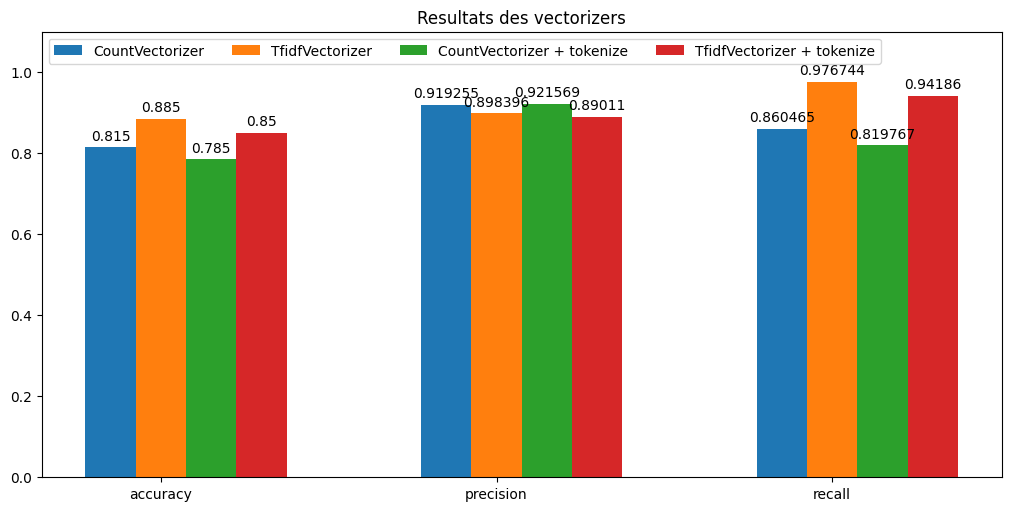

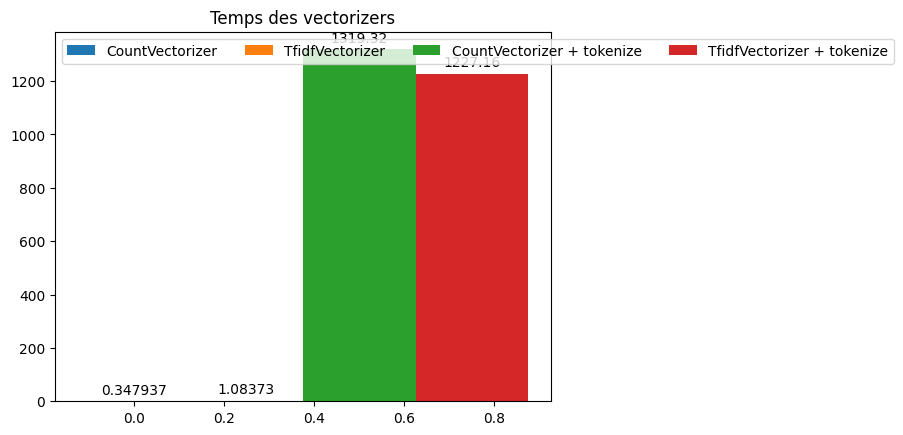

In [11]:
variables = ("accuracy", "precision", "recall")
vectorizers = {
    "CountVectorizer": l[0][:3], #(0.815, 0.9192546583850931, 0.8604651162790697, 0.22707438468933105)
    "TfidfVectorizer": l[1][:3], #(0.885, 0.8983957219251337, 0.9767441860465116, 0.6280872821807861)
    "CountVectorizer + tokenize": l[2][:3], #(0.785, 0.9215686274509803, 0.8197674418604651, 1332.5538396835327)
    "TfidfVectorizer + tokenize": l[3][:3] #(0.85, 0.8901098901098901, 0.9418604651162791, 1109.1495220661163)
}

x = np.arange(len(variables))  # the label locations
width = 0.15 # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(10, 5))
for attribute, measurement in vectorizers.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_title('Resultats des vectorizers')
ax.set_xticks(x + width, variables)
ax.legend(loc='upper left', ncols=len(vectorizers))
ax.set_ylim(0, 1.1)
plt.show()


variables = ("temps")
vectorizers = {
    "CountVectorizer": l[0][3], #(0.815, 0.9192546583850931, 0.8604651162790697, 0.22707438468933105)
    "TfidfVectorizer": l[1][3], #(0.885, 0.8983957219251337, 0.9767441860465116, 0.6280872821807861)
    "CountVectorizer + tokenize": l[2][3], #(0.785, 0.9215686274509803, 0.8197674418604651, 1332.5538396835327)
    "TfidfVectorizer + tokenize": l[3][3] #(0.85, 0.8901098901098901, 0.9418604651162791, 1109.1495220661163)
}
width = 0.25 # the width of the bars
multiplier = 0
fig, ax = plt.subplots()
for attribute, measurement in vectorizers.items():
    offset = width * multiplier
    rects = ax.bar(offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_title('Temps des vectorizers')
ax.legend(loc='upper left', ncols=len(vectorizers))

plt.show()

### a modifier
Le 1er vectorizer n'utilise pas la fonction tokenizer, il ne transforme donc pas les phrases en tokens lemmatisés et ne supprime pas les mots d'arret.
Le 2e vectorizer utilise la fonction tokenizer, qui supprime les mots d'arret et lemmatise les autres mots.

La 1ere pipeline met 0.6s pour s'entrainer et prédire un jeu comportant 1000 données, tandis que la 2eme pipeline met environ 19 minutes, car la tokenisation est très longue.
Au final, le résultat est très similaire, voire un peu meilleur pour la 1ere pipeline.

Pour la suite, nous n'allons donc pas utiliser de tokenizer, et nous garderons ainsi les phrases avec tous leurs mots, sans lemmes. On va aussi augmenter la taille des données, pour assurer des prédictions plus précises.

## Tests des hyperparamètres du classifieur

In [66]:
def vectorize_col(data, col):
    vectorizer = TfidfVectorizer()
    data[col] = clean_text(data[col])
    data[col] = list(vectorizer.fit_transform(data[col]).toarray())
    return data


In [69]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

def grid_search(data, attr, target, param_grid):
    x = data[attr]
    y = data[target]
    print(x[0])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid)
    print(x_train.shape)
    print(x_train.dtypes)
    print(x_train)
    grid_search.fit(x_train, y_train)
    print(grid_search.score(x_test, y_test))
    return grid_search.best_params_, grid_search.best_score_

In [70]:
data_vectorized = vectorize_col(data_filtered[:1000], "review_text")
best_params, best_score = grid_search(data_vectorized, "review_text", "favorable", param_grid)

/tmp/ipykernel_803/509374549.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = clean_text(data[col])
/tmp/ipykernel_803/509374549.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = list(vectorizer.fit_transform(data[col]).toarray())


[0. 0. 0. ... 0. 0. 0.]
(800,)
object
188    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
194    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
225    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
580    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
428    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                             ...                        
320    [0.0, 0.0, 0.0, 0.0, 0.0, 0.3352481289005435, ...
527    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
996    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
125    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
265    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: review_text, Length: 800, dtype: object


ValueError: 
All the 100 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
TypeError: only length-1 arrays can be converted to Python scalars

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/var/home/E210826J/reseau/Perso/Documents/A3/saemaths/predictReviewNote/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/var/home/E210826J/reseau/Perso/Documents/A3/saemaths/predictReviewNote/.venv/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/var/home/E210826J/reseau/Perso/Documents/A3/saemaths/predictReviewNote/.venv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py", line 233, in fit
    return self._fit(X, y)
  File "/var/home/E210826J/reseau/Perso/Documents/A3/saemaths/predictReviewNote/.venv/lib/python3.10/site-packages/sklearn/neighbors/_base.py", line 456, in _fit
    X, y = self._validate_data(
  File "/var/home/E210826J/reseau/Perso/Documents/A3/saemaths/predictReviewNote/.venv/lib/python3.10/site-packages/sklearn/base.py", line 622, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/var/home/E210826J/reseau/Perso/Documents/A3/saemaths/predictReviewNote/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1146, in check_X_y
    X = check_array(
  File "/var/home/E210826J/reseau/Perso/Documents/A3/saemaths/predictReviewNote/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py", line 915, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/var/home/E210826J/reseau/Perso/Documents/A3/saemaths/predictReviewNote/.venv/lib/python3.10/site-packages/sklearn/utils/_array_api.py", line 380, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/var/home/E210826J/reseau/Perso/Documents/A3/saemaths/predictReviewNote/.venv/lib/python3.10/site-packages/pandas/core/series.py", line 953, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: setting an array element with a sequence.


# Partie 3 : Classification multi-classe

## Test des hyperparamètres

In [ ]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
best_params, best_score = grid_search(data_vectorized, "review_text", "rating", param_grid)

In [ ]:
print(best_params, best_score)